<a href="https://colab.research.google.com/github/abuhurera8320/Hate_Speech_Detection/blob/main/Roman_Urdu_Hate_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import Conv1D,LSTM,Dense,Embedding,RepeatVector,TimeDistributed,Bidirectional,GRU,SimpleRNN
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
from IPython.display import Markdown, display
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [3]:
df=pd.read_csv('/content/drive/MyDrive/FYP /task_1_train.tsv', sep='\t')

In [4]:
df.columns=['Text','Label']
df.count()

Text     7208
Label    7208
dtype: int64

In [5]:
l=df['Label'].unique()
l_dict={0:'Abusive/Offensive',1:'Normal'}
for i in l:
    print('Label {} is for {}'.format(i,l_dict[i]))

Label 0 is for Abusive/Offensive
Label 1 is for Normal


In [6]:
offensivedf=df.loc[df['Label']==1]
offensivedf.count()

Text     3850
Label    3850
dtype: int64

In [7]:
df1=pd.read_csv('/content/drive/MyDrive/FYP /task_1_test.tsv', sep='\t')

In [8]:
df1.columns=['Text','Label']
df1.count()

Text     2002
Label    2002
dtype: int64

In [9]:
offensivedf=df1.loc[df1['Label']==1]
offensivedf.count()

Text     1069
Label    1069
dtype: int64

In [10]:
Neutral=df.loc[df['Label']==1]
Neutral.head()

,Text,Label
6,hum kisi se km nhi,1
7,aurat bhatak sakri hy kbi “maa” ni bhatakti . ...,1
10,with due respect sir kya aurat march se ye ch...,1
15,😂😂😂😂😂😂 chal ja tujhy maaf kia,1
16,agr ap chahtay hn k log ap ko acha kahean to a...,1


In [11]:
hate=df.loc[df['Label']==0]
hate.head()

,Text,Label
0,bhaunk bhaunk ke pagal ho jaata ab tak....,0
1,shivsaina nam mulla saina rakh hijra uddh...,0
2,there are some yahodi daboo like imran chore z...,0
3,"chutiye ye hunduism ni he islam he , isme koi ...",0
4,han g rakhail e awal kiya bak rai hai. kisay a...,0


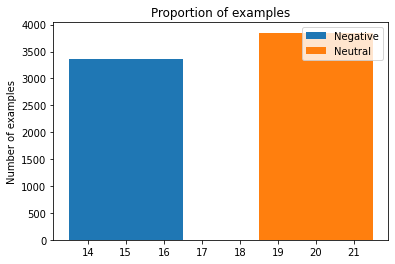

In [12]:
Neu = df[df['Label'] == 1].shape[0]
Neg = df[df['Label'] == 0].shape[0]
# bar plot of the 3 classes
plt.bar(15,Neg,3, label="Negative")
plt.bar(20,Neu,3, label="Neutral")
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

In [13]:
newdata=pd.read_csv('/content/drive/MyDrive/FYP /newdata.csv')
newdata.shape

(9210, 3)

In [14]:
newdata.head()

,Unnamed: 0,Text,Label
0,0,ni ab to jo marzi ho jay biyah tum say he kar...,1
1,1,kaayar means leftists jo randiyo ki tarah rone...,0
2,2,kya samjh nhi aaya mochi..saf or seedhi baat h...,0
3,3,itni syani kb sy ho gai tum😂😂,1
4,4,tou phir baji dedo usko apnii kisii nachnay wa...,0


In [15]:
df = pd.concat([df, df1,newdata], ignore_index=True, sort=False)

In [16]:
df.shape

(18420, 3)

## Data Preprocessing
#### 1. Removing Punctuations
#### 2. Converting to Lower case
#### 3. Removing stopwords

In [17]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [18]:
import re
def remove_punct(text):
    ''' Input parameter:
    text: (str)
    this method is used to take each text line and check the characters if it
    contains any puntuation and then remove them with blank space'''  
    text  = "".join([char for [char] in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text


In [19]:
# removing all the punctuation
df['Text'] = df['Text'].apply(lambda x: remove_punct(str(x))) 

In [20]:
df['Text'].head()

0               bhaunk bhaunk ke pagal ho jaata ab tak
1    shivsaina  nam mulla  saina  rakh  hijra  uddh...
2    there are some yahodi daboo like imran chore z...
3    chutiye ye hunduism ni he islam he  isme koi k...
4    han g rakhail e awal kiya bak rai hai kisay ah...
Name: Text, dtype: object

#### Converting the text corpus to Lower Case

In [21]:
def convert_to_lower_case(text):
    ''' Input parameter:
    text: (str)
    this method is used to take each text line and converts the characters  into lower case and joins them further'''
    text  = "".join([char.lower() for [char] in text if char not in string.punctuation])
    return text


In [22]:
df['Text'] = df['Text'].apply(lambda x: convert_to_lower_case(str(x))) #calling lower case on each line

In [23]:
df['Text'].head()

0               bhaunk bhaunk ke pagal ho jaata ab tak
1    shivsaina  nam mulla  saina  rakh  hijra  uddh...
2    there are some yahodi daboo like imran chore z...
3    chutiye ye hunduism ni he islam he  isme koi k...
4    han g rakhail e awal kiya bak rai hai kisay ah...
Name: Text, dtype: object

### Removing Stopwords

In [24]:
stopwords=['ai', 'ayi', 'hy', 'hai', 'main', 'ki', 'tha', 'koi', 'ko', 'sy', 'woh', 'bhi', 'aur', 'wo', 'yeh', 'rha', 
           'hota', 'ho', 'ga', 'ka', 'le', 'lye', 'kr', 'kar', 'lye', 'liye', 'hotay', 'waisay', 'gya', 'gaya', 'kch',
           'ab', 'thy', 'thay', 'houn', 'hain', 'han', 'to','is', 'hi', 'jo', 'kya', 'thi', 'se', 'pe', 'phr', 'wala',
           'waisay', 'us', 'na', 'ny', 'hun', 'rha', 'raha', 'ja', 'rahay', 'abi', 'uski', 'ne', 'haan', 'acha', 'nai',
           'sent', 'you', 'kafi', 'gai', 'rhy', 'kuch', 'jata', 'aye', 'ya', 'dono', 'hoa', 'aese', 'de', 'wohi',
           'jati', 'jb', 'krta', 'lg', 'rahi', 'hui', 'karna', 'krna', 'gi', 'hova', 'yehi', 'jana', 'jye', 'chal', 'mil',
           'tu', 'hum', 'par', 'hay', 'kis', 'sb', 'gy', 'dain', 'krny', 'tou','h','je','or','jee','he','in','un','kay','ki','ya','ap','meri','me']


In [25]:
dictStopWords = {} # global variable
forFastTextData = []
def removeStopWordss(text):
    text = re.sub('[^a-zA-Z]',' ',str(text))
    text = text.lower()
    wordList =str(text).split()
    for word in wordList:
        if word in stopwords:
            wordList.remove(word)
            if word not in dictStopWords:
                dictStopWords[word]= 1
            else:
                dictStopWords[word] = dictStopWords[word] + 1
    newSentence = " ".join(wordList)
    forFastTextData.append(newSentence.split())
    return (newSentence)

In [26]:
df['Text'] = df['Text'].apply(lambda x: removeStopWordss(x)) # sentence with removed stop words

In [27]:
## checking for most common stopwords from the dictionary
import collections
from collections import Counter
dictGraph = {}
d = Counter(dictStopWords) # creating a counter 
d.most_common(10) 
for k,v in d.most_common(10):
    dictGraph[k] = v
dictGraph

{'hai': 4897,
 'hain': 1552,
 'ho': 2305,
 'ka': 2978,
 'ki': 4408,
 'ko': 3615,
 'me': 1450,
 'na': 1423,
 'se': 2251,
 'to': 2726}

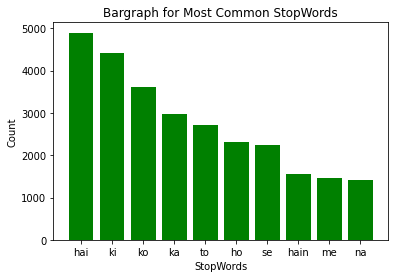

In [28]:
#plotting a graph of 10 most common stopwords from dictionary
plt.bar(dictGraph.keys(), dictGraph.values(), align='center', color = 'green')
plt.title('Bargraph for Most Common StopWords')
plt.xlabel('StopWords')
plt.ylabel('Count')
plt.show()

In [29]:
sum(dictGraph.values())

27605

In [30]:
df.to_csv('/content/drive/MyDrive/FYP /preprocessed_df.csv')

### Removal of Characters(Stemming)

In [ ]:
def replacing_characters(word):
    ''' Input Parameter: 
    word: word from the sentences'''
 
    word = re.sub(r'ain$', r'ein', word)
    word = re.sub(r'ai', r'ae', word)
    word = re.sub(r'ay$', r'e', word)
    word = re.sub(r'ey$', r'e', word)
    word = re.sub(r'aa+', r'aa', word)
    word = re.sub(r'e+', r'ee', word)
    word = re.sub(r'ai', r'ahi', word) # e.g "sahi and sai nahi"
    word = re.sub(r'ai', r'ahi', word)
    word = re.sub(r'ie$', r'y', word)
    word = re.sub(r'^es', r'is', word)
    word = re.sub(r'a+', r'a', word)
    word = re.sub(r'j+', r'j', word)
    word = re.sub(r'd+', r'd', word)
    word = re.sub(r'u', r'o', word)
    word = re.sub(r'o+', r'o', word)
    if not re.match(r'ar', word):
        word = re.sub(r'ar', r'r', word)
        word = re.sub(r'iy+', r'i', word)
        word = re.sub(r'ih+', r'eh', word)
        word = re.sub(r's+', r's', word)
    if re.search(r'[rst]y', 'word') and word[-1] != 'y':
        word = re.sub(r'y', r'i', word)
    if re.search(r'[^a]i', word):
        word = re.sub(r'i$', r'y', word)
    if re.search(r'[a-z]h', word):
        word = re.sub(r'h', '', word)
    return word

In [ ]:
df['Text'] = df['Text'].apply(lambda x: replacing_characters(x))

In [3]:

df=pd.read_csv('/content/drive/MyDrive/FYP /preprocessed_df.csv')
df.shape

(18420, 4)

In [4]:
df['Text'].head()

0                     bhaunk bhaunk ke pagal jaata tak
1    shivsaina nam mulla saina rakh hijra uddhav th...
2    there are some yahodi daboo like imran chore z...
3    chutiye ye hunduism ni islam isme kisi muslim ...
4    g rakhail e awal kiya bak rai kisay ahmaq kah ...
Name: Text, dtype: object

**Tokenization and Test Train Split**

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X=df['Text']
y=df['Label']
X.shape

(18420,)

In [7]:
count = df['Text'].str.split().apply(len)
count=count.sort_values(axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
MAX_SEQUENCE_LENGTH=count.iloc[0]+10
MAX_SEQUENCE_LENGTH

66

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 22847


In [9]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [10]:

X_train = pad_sequences((tokenizer.texts_to_sequences(X_train)),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                      maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (14736, 66)
Testing X Shape: (3684, 66)


In [11]:
print(f'train data:{X_train.shape}, train labels:{y_train.shape},test data:{X_test.shape}, test labels:{y_test.shape}')

train data:(14736, 66), train labels:(14736,),test data:(3684, 66), test labels:(3684,)


## Importing Pretrained Word2vec embeddings

In [12]:
# load embeding for text file
embeddings_index1 = dict()
f = open('/content/drive/MyDrive/FYP /vectors500000.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index1[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index1))

Loaded 31308 word vectors.


In [13]:
# load embeding for text file
embeddings_index2 = dict()
f = open('/content/drive/MyDrive/FYP /word2vec_RU.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index2[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index2))

Loaded 20838 word vectors.


In [14]:
count=0
wordcount1=0
wordcount2=0
dims=100
flag=1
#word_index = {w: i for i, w in enumerate(embeddings_index, 1)}
embedding_matrix = np.zeros((len(word_index)+1, dims))
for word, i in word_index.items():
  if word in embeddings_index1.keys():
    embedding_vector = embeddings_index1.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector[:dims]
        wordcount1 +=1
        
  elif word in embeddings_index2.keys():
        embedding_vector = embeddings_index2.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
         embedding_matrix[i] = embedding_vector[:dims]
         wordcount2 +=1
        
  else:
     count +=1
     
      

In [15]:
print('Embedding Stats :')
print(f'Words found in first embedding: {wordcount1}')
print(f'Words found in second embedding: {wordcount2}')
print(f'Words not found in any embedding: {count}')
print(f'Total words found in both embeddings: {wordcount1+wordcount2}')

Embedding Stats :
Words found in first embedding: 10101
Words found in second embedding: 11237
Words not found in any embedding: 1508
Total words found in both embeddings: 21338


In [16]:
embedding_matrix.shape

(22847, 100)

In [17]:
#sequences= X.apply(lambda x:text_to_word_sequence(x))

##**Simple RNN's**

In [18]:
#%%time
#with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False))
model.add(Dropout(0.2))
model.add(SimpleRNN(20))
model.add(Dropout(0.2))
model.add(Dense(200,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 100)           2284700   
                                                                 
 dropout (Dropout)           (None, 66, 100)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20)                2420      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 200)               4200      
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 1)                 1

In [19]:
history=model.fit(X_train, y_train, epochs=5, batch_size=128,validation_data=(X_test, y_test),verbose=1)

Epoch 1/5
116/116 [==============================] - 10s 73ms/step - loss: 0.6836 - accuracy: 0.5571 - val_loss: 0.6668 - val_accuracy: 0.5841
Epoch 2/5
116/116 [==============================] - 12s 100ms/step - loss: 0.6732 - accuracy: 0.5763 - val_loss: 0.6538 - val_accuracy: 0.6083
Epoch 3/5
116/116 [==============================] - 6s 55ms/step - loss: 0.6703 - accuracy: 0.5817 - val_loss: 0.6490 - val_accuracy: 0.6159
Epoch 4/5
116/116 [==============================] - 6s 56ms/step - loss: 0.6629 - accuracy: 0.5941 - val_loss: 0.6417 - val_accuracy: 0.6232
Epoch 5/5
116/116 [==============================] - 6s 56ms/step - loss: 0.6607 - accuracy: 0.5885 - val_loss: 0.6365 - val_accuracy: 0.6270


In [20]:
from sklearn import metrics
def decode_sentiment(score):
    return 1 if score>0.5 else 0

In [21]:

scores = model.predict(X_test)
#print(y_pred.shape)
#y_pred = np.argmax(y_pred, axis=1)
#print(y_pred.shape)

#
y_pred = [decode_sentiment(score) for score in scores]
metrics.accuracy_score(y_test, y_pred)

0.6270358306188925

In [22]:
print("classification report:")
print(metrics.classification_report(y_test, y_pred))#, target_names=target_names))

classification report:
              precision    recall  f1-score   support

           0       0.65      0.43      0.52      1725
           1       0.61      0.80      0.70      1959

    accuracy                           0.63      3684
   macro avg       0.63      0.62      0.61      3684
weighted avg       0.63      0.63      0.61      3684



In [23]:
print("confusion matrix: ")
print(metrics.confusion_matrix(y_test, y_pred))

confusion matrix: 
[[ 742  983]
 [ 391 1568]]


Text(0.5, 1.0, 'Loss evolution')

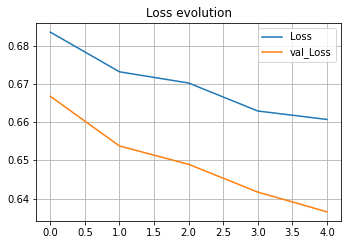

In [24]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')


Text(0.5, 1.0, 'Accuracy evolution')

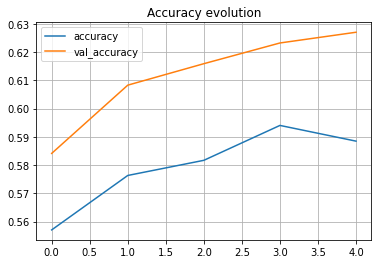

In [25]:
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

## **Bi-Directional LSTM**

In [26]:

model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False))

#model.add(Dropout(0.25))
#model.add(Conv1D(128, 3, activation='relu'))
model.add(Bidirectional(LSTM(300)))
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
#ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss',verbose = 1)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 66, 100)           2284700   
                                                                 
 bidirectional (Bidirectiona  (None, 600)              962400    
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 512)               307712    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,686,397
Trainable params: 1,401,697
Non-trainable params: 2,284,700
____________________________________

In [27]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
116/116 [==============================] - 8s 33ms/step - loss: 0.4906 - accuracy: 0.7600 - val_loss: 0.3949 - val_accuracy: 0.8431
Epoch 2/10
116/116 [==============================] - 3s 26ms/step - loss: 0.2143 - accuracy: 0.9140 - val_loss: 0.3071 - val_accuracy: 0.8933
Epoch 3/10
116/116 [==============================] - 3s 28ms/step - loss: 0.1482 - accuracy: 0.9492 - val_loss: 0.2979 - val_accuracy: 0.9091
Epoch 4/10
116/116 [==============================] - 3s 28ms/step - loss: 0.1021 - accuracy: 0.9625 - val_loss: 0.2912 - val_accuracy: 0.9083
Epoch 5/10
116/116 [==============================] - 3s 26ms/step - loss: 0.0783 - accuracy: 0.9702 - val_loss: 0.3167 - val_accuracy: 0.9077
Epoch 6/10
116/116 [==============================] - 3s 26ms/step - loss: 0.0732 - accuracy: 0.9734 - val_loss: 0.2918 - val_accuracy: 0.9126
Epoch 7/10
116/116 [==============================] - 3s 27ms/step - loss: 0.0584 - accuracy: 0.9786 - val_loss: 0.3018 - val_accuracy: 0.9232

In [36]:

scores = model.predict(X_test)
#print(y_pred.shape)
#y_pred = np.argmax(y_pred, axis=1)
#print(y_pred.shape)

#
y_pred = [decode_sentiment(score) for score in scores]
accuracy=metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy of Bi-Lstm is {accuracy:.2f}%')

Accuracy of Bi-Lstm is 0.92%


In [29]:
print("classification report:")
print(metrics.classification_report(y_test, y_pred))#, target_names=target_names))

classification report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1725
           1       0.93      0.92      0.93      1959

    accuracy                           0.92      3684
   macro avg       0.92      0.92      0.92      3684
weighted avg       0.92      0.92      0.92      3684



In [30]:
print("confusion matrix: ")
print(metrics.confusion_matrix(y_test, y_pred))

confusion matrix: 
[[1591  134]
 [ 149 1810]]


Text(0.5, 1.0, 'Loss evolution')

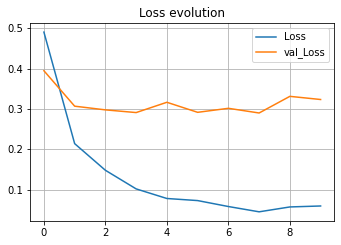

In [31]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy evolution')

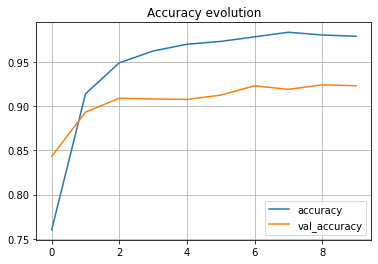

In [32]:
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')

In [33]:
# To save the model:

from keras.models import save_model

# you can write whatever you desire instead of 'my_model'
# model = Your trained model
model.save('/content/drive/MyDrive/FYP /mymodel')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FYP /mymodel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FYP /mymodel/assets


# **GRU's**

In [66]:
   # GRU with Word2Vec embeddings and two dense layers
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False))
#model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(GRU(300,dropout=0.3)))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 66, 100)           2284700   
                                                                 
 bidirectional_1 (Bidirectio  (None, 600)              723600    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 256)               153856    
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,162,413
Trainable params: 877,713
Non-trainable params: 2,284,700
_________________________________________________________________


In [67]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
231/231 [==============================] - 7s 19ms/step - loss: 0.6449 - accuracy: 0.6268 - val_loss: 0.5593 - val_accuracy: 0.6987
Epoch 2/10
231/231 [==============================] - 4s 16ms/step - loss: 0.5800 - accuracy: 0.6864 - val_loss: 0.5194 - val_accuracy: 0.7307
Epoch 3/10
231/231 [==============================] - 4s 16ms/step - loss: 0.5431 - accuracy: 0.7183 - val_loss: 0.4936 - val_accuracy: 0.7565
Epoch 4/10
231/231 [==============================] - 4s 16ms/step - loss: 0.5271 - accuracy: 0.7350 - val_loss: 0.4996 - val_accuracy: 0.7476
Epoch 5/10
231/231 [==============================] - 4s 16ms/step - loss: 0.5012 - accuracy: 0.7469 - val_loss: 0.4687 - val_accuracy: 0.7736
Epoch 6/10
231/231 [==============================] - 4s 16ms/step - loss: 0.4795 - accuracy: 0.7683 - val_loss: 0.4571 - val_accuracy: 0.7790
Epoch 7/10
231/231 [==============================] - 4s 16ms/step - loss: 0.4668 - accuracy: 0.7778 - val_loss: 0.4535 - val_accuracy: 0.7761

In [68]:

scores = model.predict(X_test)
#print(y_pred.shape)
#y_pred = np.argmax(y_pred, axis=1)
#print(y_pred.shape)

#
y_pred = [decode_sentiment(score) for score in scores]
metrics.accuracy_score(y_test, y_pred)

0.8013029315960912

In [69]:
print("classification report:")
print(metrics.classification_report(y_test, y_pred))#, target_names=target_names))

classification report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1725
           1       0.82      0.81      0.81      1959

    accuracy                           0.80      3684
   macro avg       0.80      0.80      0.80      3684
weighted avg       0.80      0.80      0.80      3684



In [70]:
print("confusion matrix: ")
print(metrics.confusion_matrix(y_test, y_pred))

confusion matrix: 
[[1372  353]
 [ 379 1580]]


Text(0.5, 1.0, 'Loss evolution')

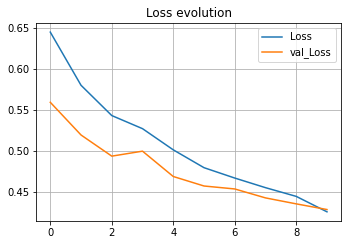

In [71]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

Text(0.5, 1.0, 'Accuracy evolution')

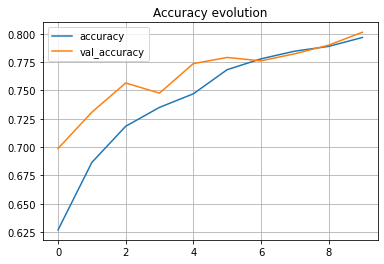

In [72]:
plt.subplot(1, 1, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy evolution')